### IMPORT LIBRARIES

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# evaluation metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras import metrics
# scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# autoencoder
import tensorflow as tf
from tensorflow import keras

# deep learning
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras.optimizers import Adam

from tensorflow.python.framework.ops import disable_eager_execution


### LOADING DATASET

In [2]:
credit_card = pd.read_excel("card transactions.xlsx")

### DATA PREPROCESSING 

In [3]:
credit_card.shape

(96753, 10)

In [4]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96753 non-null  int64         
 1   Cardnum            96753 non-null  int64         
 2   Date               96753 non-null  datetime64[ns]
 3   Merchnum           93378 non-null  object        
 4   Merch description  96753 non-null  object        
 5   Merch state        95558 non-null  object        
 6   Merch zip          92097 non-null  float64       
 7   Transtype          96753 non-null  object        
 8   Amount             96753 non-null  float64       
 9   Fraud              96753 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.4+ MB


### EXTRACT DAY AND MONTH FOR FURTHER ANALYSIS

In [5]:
day =pd.to_datetime(credit_card['Date']).dt.dayofweek
month =pd.to_datetime(credit_card['Date']).dt.month
credit_card.insert(1, 'day', day)
credit_card.insert(2, 'month', month)
credit_card = credit_card.drop('Date', axis = 1)

In [6]:
dict_populated = {}
for i in credit_card.columns.to_list():
    dict_populated[i] = credit_card[i].count()/len(credit_card)*100
dict_populated

{'Recnum': 100.0,
 'day': 100.0,
 'month': 100.0,
 'Cardnum': 100.0,
 'Merchnum': 96.51173607019938,
 'Merch description': 100.0,
 'Merch state': 98.76489617892985,
 'Merch zip': 95.1877461163995,
 'Transtype': 100.0,
 'Amount': 100.0,
 'Fraud': 100.0}

### CHECKING FOR NULL VALUES

In [7]:
credit_card.isnull().sum()

Recnum                  0
day                     0
month                   0
Cardnum                 0
Merchnum             3375
Merch description       0
Merch state          1195
Merch zip            4656
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

### DROPPING THE NULL VALUES

In [8]:
credit_card = credit_card.dropna()
credit_card

,Recnum,day,month,Cardnum,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,4,1,5142190439,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,4,1,5142183973,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,4,1,5142131721,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,4,1,5142148452,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,4,1,5142190439,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
...,...,...,...,...,...,...,...,...,...,...,...
96748,96749,4,12,5142276053,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0
96749,96750,4,12,5142225701,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0
96750,96751,4,12,5142226486,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0
96751,96752,4,12,5142244619,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0


### UNIQUE VALUES

In [9]:
dict_unique = {}
for i in credit_card.columns.to_list():
    dict_unique[i]=len(credit_card[i].unique())
dict_unique

{'Recnum': 90198,
 'day': 7,
 'month': 12,
 'Cardnum': 1622,
 'Merchnum': 12807,
 'Merch description': 12184,
 'Merch state': 51,
 'Merch zip': 4452,
 'Transtype': 1,
 'Amount': 33878,
 'Fraud': 2}

### CHECKING FOR DUPLICATES

In [10]:
credit_card.duplicated().sum()

0

### STATISTICS SUMMARY

In [11]:
credit_card.describe()

,Recnum,day,month,Cardnum,Merch zip,Amount,Fraud
count,90198.000000,90198.000000,90198.000000,9.019800e+04,90198.000000,90198.000000,90198.000000
mean,48355.064835,2.571576,6.320063,5.142202e+09,44581.840872,397.266831,0.011331
std,27697.328106,2.109709,3.210985,5.589836e+04,28269.803688,816.286539,0.105841
min,1.000000,0.000000,1.000000,5.142110e+09,1.000000,0.010000,0.000000
25%,24550.250000,1.000000,4.000000,5.142151e+09,20854.000000,33.780000,0.000000
50%,48459.500000,2.000000,6.000000,5.142196e+09,38118.000000,139.000000,0.000000
75%,72101.750000,5.000000,9.000000,5.142245e+09,63103.000000,429.977500,0.000000
max,96753.000000,6.000000,12.000000,5.142847e+09,99999.000000,30372.460000,1.000000


### EXPLORING THE DATASET

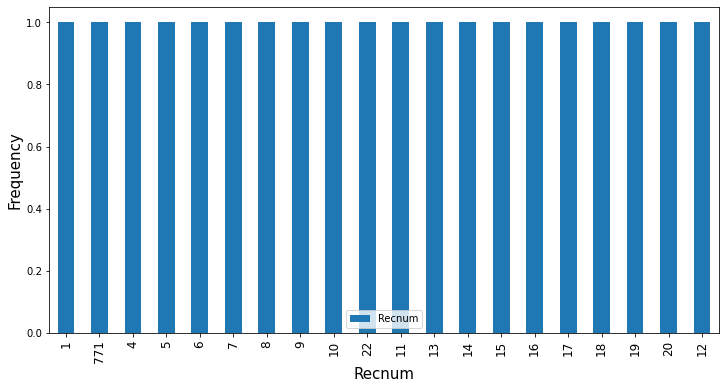

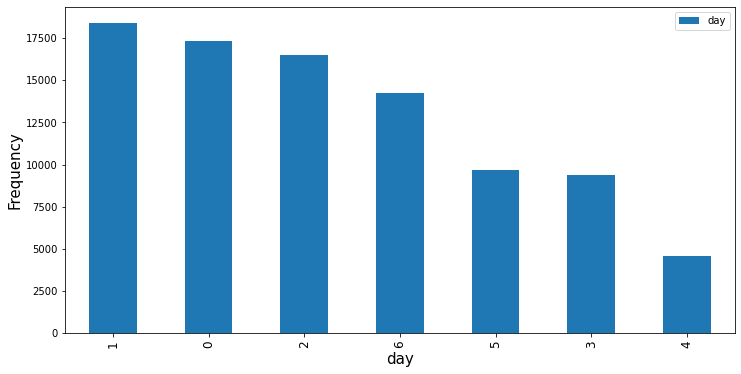

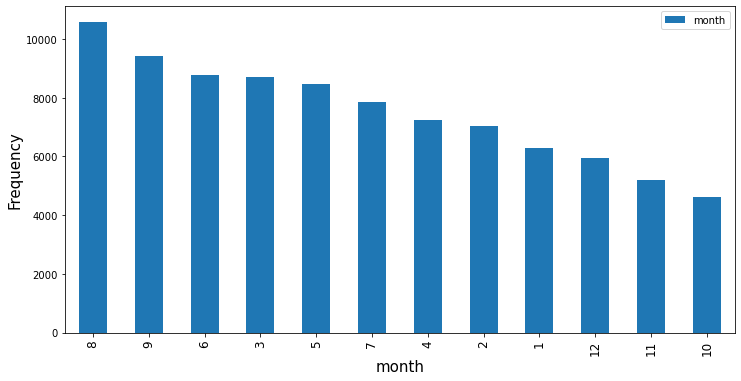

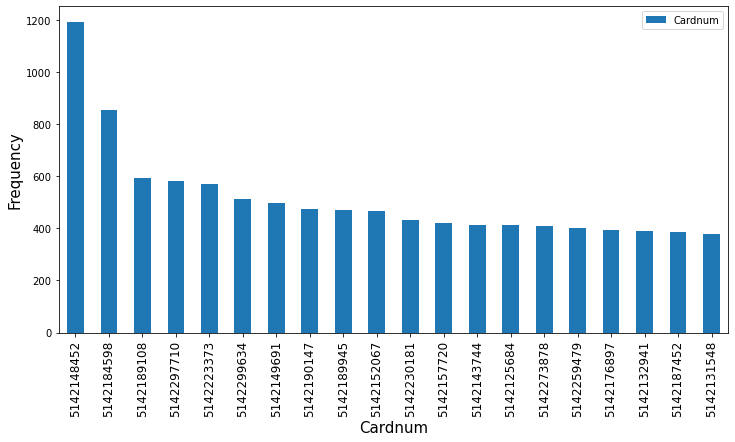

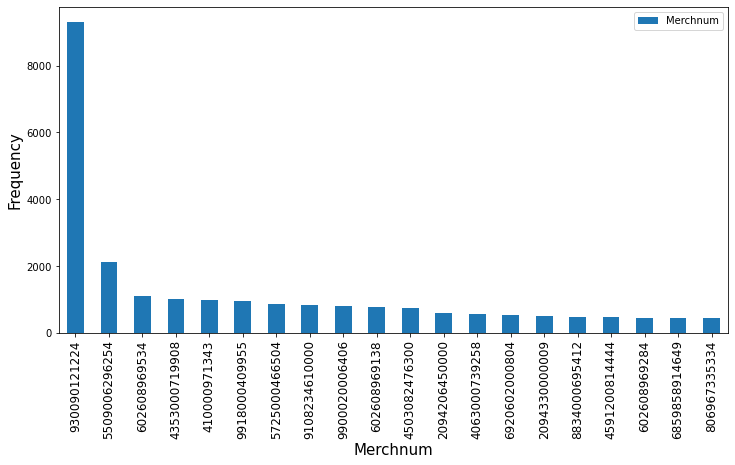

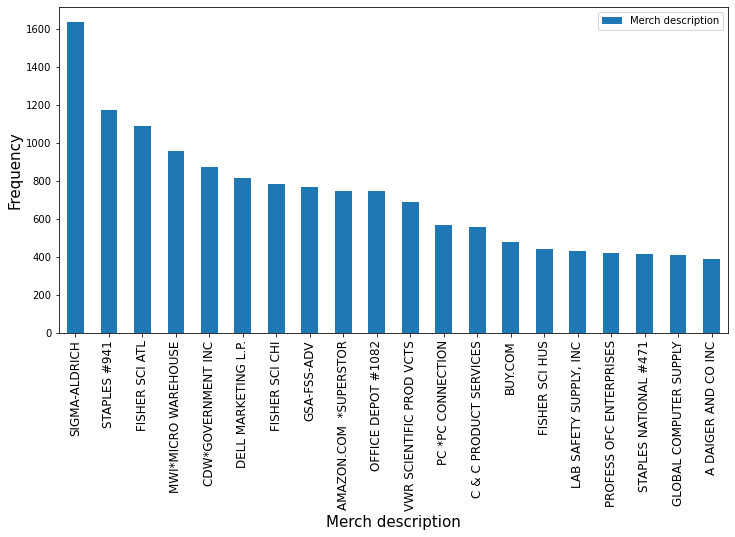

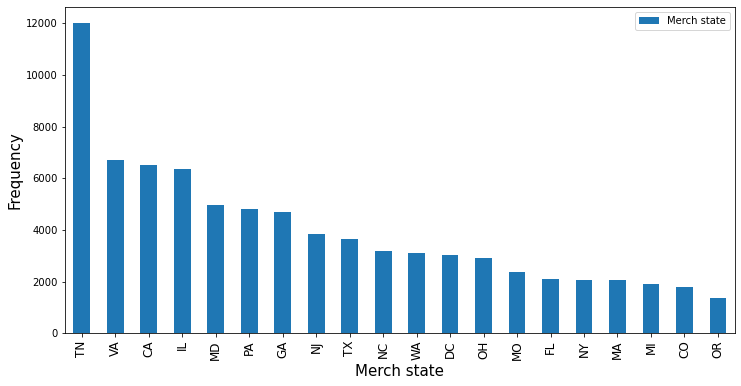

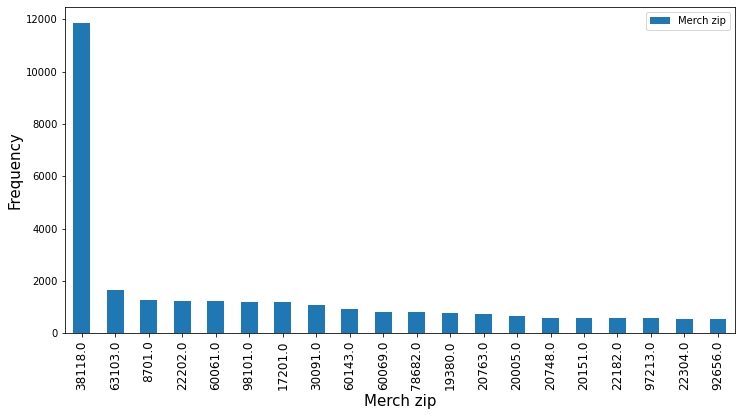

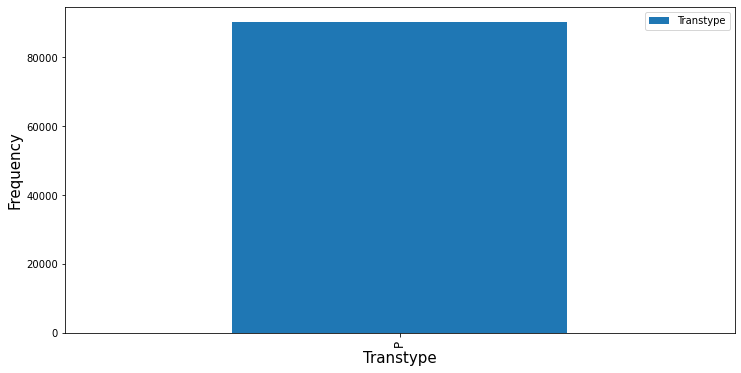

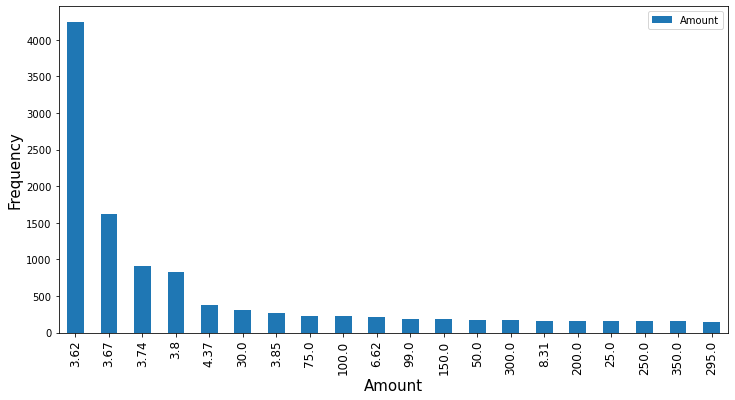

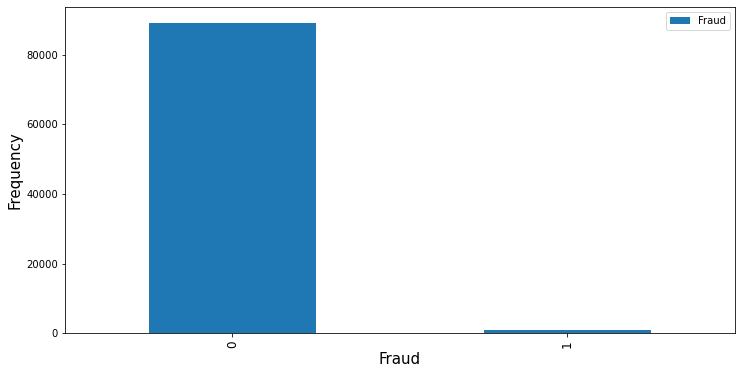

In [12]:
categoricalVar = credit_card.columns.tolist()
for col in categoricalVar:
    df = pd.DataFrame(credit_card[col].value_counts().sort_values(ascending=False).head(20))
    df.plot(kind='bar',figsize=(12,6))
    plt.xlabel(col,fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=12)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

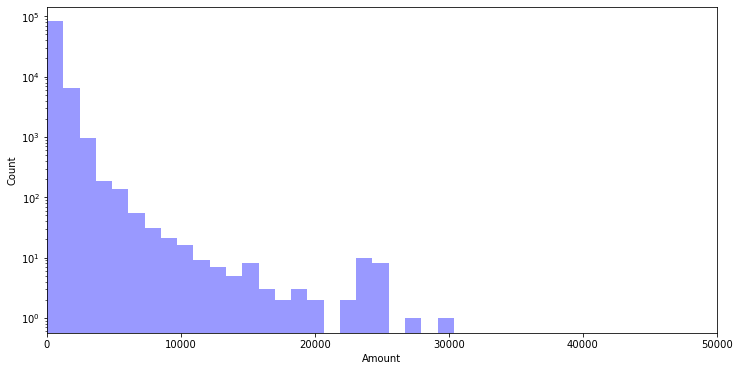

In [13]:
plt.rcParams["figure.figsize"] = [12,6]
xhigh = 50000
plt.xlim(0,xhigh)
temp = credit_card[credit_card['Amount'] <= xhigh]
sns.set_palette("deep")
plot=sns.distplot(temp['Amount'],bins=25, kde=False, color='blue')
plot.set_yscale('log')
plt.ylabel('Count')

Text(0.5, 0, 'Amount')

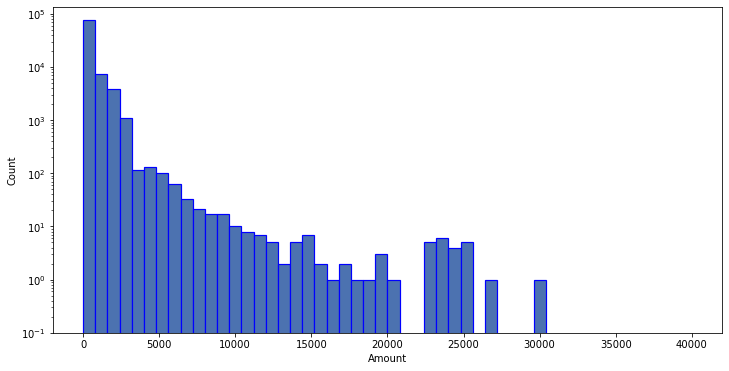

In [14]:
plt.hist(credit_card['Amount'],bins=50,range=[0,40000],edgecolor='blue',linewidth=1.2)
plt.yscale('log')
plt.ylim(bottom = .1)
plt.ylabel('Count')
plt.xlabel('Amount')

### CORRELATION ANALYSIS

In [15]:
credit_card_corr = credit_card.corr()['Fraud'].abs().sort_values(ascending=False)
credit_card_corr

Fraud        1.000000
Amount       0.217197
Cardnum      0.042390
month        0.037741
Recnum       0.037017
Merch zip    0.032984
day          0.014640
Name: Fraud, dtype: float64

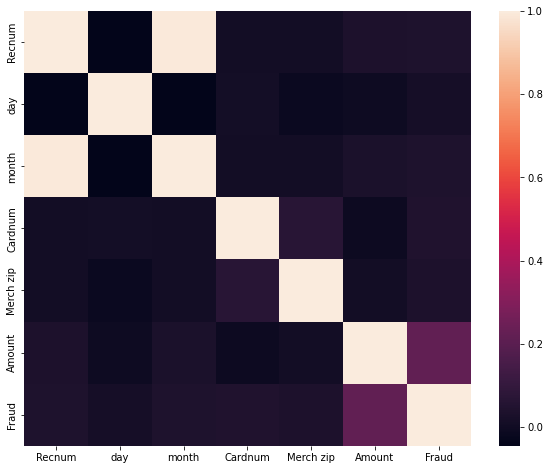

In [16]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(credit_card.corr())
plt.show()

The correlation plot shows no presence of multi collinearity amongst the features (PCA components). All of these features does not show high correlation with the target class

### DISTRIBUTION OF TARGET CLASS

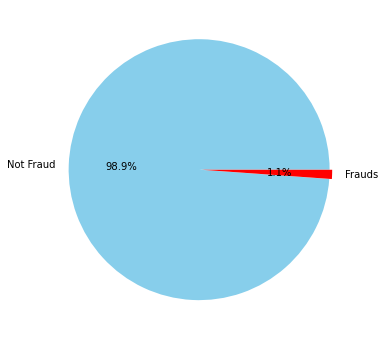

In [17]:
plt.figure(figsize=(10,6))
labels = ['Not Fraud' , 'Frauds']
explode = [.01,.01]
color = ['skyblue' , 'Red']
sizes = credit_card.Fraud.value_counts().values

plt.pie(sizes,explode,labels,autopct="%1.1f%%", colors = color)
plt.show()

The pie chart shows highly imbalanced dataset. 

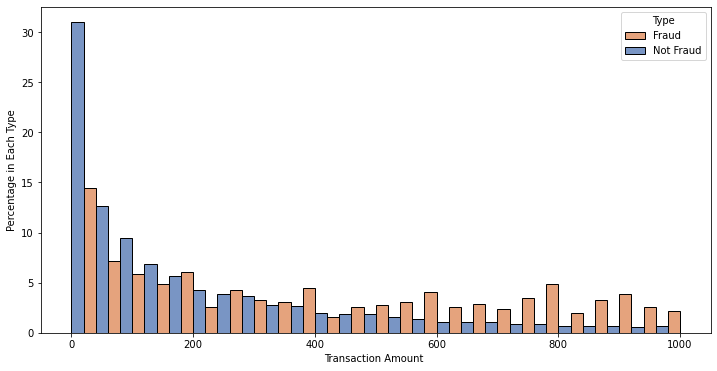

In [18]:
ax=sns.histplot(x='Amount',data=credit_card[credit_card.Amount<=1000],
                hue='Fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount ')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### STATE VS FRAUD : let's also explore which geographies are more prone to fraud. 

Text(0.5, 1.0, 'The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

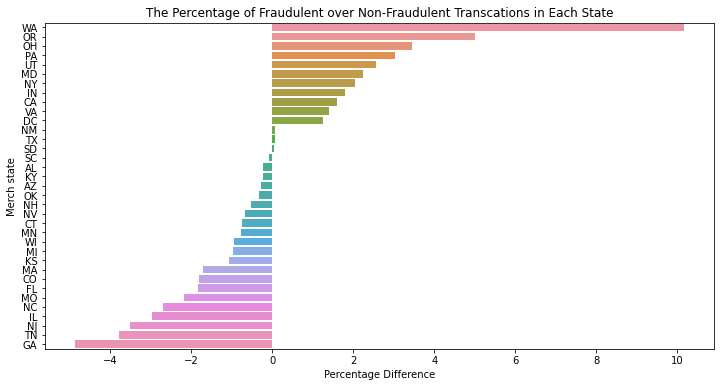

In [19]:
a=credit_card['Merch state'][credit_card.Fraud==0].value_counts(normalize=True)
a=a.to_frame()
a=a.reset_index()
a.columns = ['Merch state', 'Per']

b=credit_card['Merch state'][credit_card.Fraud==1].value_counts(normalize=True)
b=b.to_frame()
b=b.reset_index()
b.columns = ['Merch state', 'Per']

merged=a.merge(b,on='Merch state')
merged['diff']=merged['Per_y']-merged['Per_x']
merged['diff']=merged['diff']*100
merged=merged.sort_values('diff',ascending=False)

ax1=sns.barplot(data=merged, x='diff',y='Merch state')
ax1.set_xlabel('Percentage Difference')
ax1.set_ylabel('Merch state')
plt.title('The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

### Monthly trends

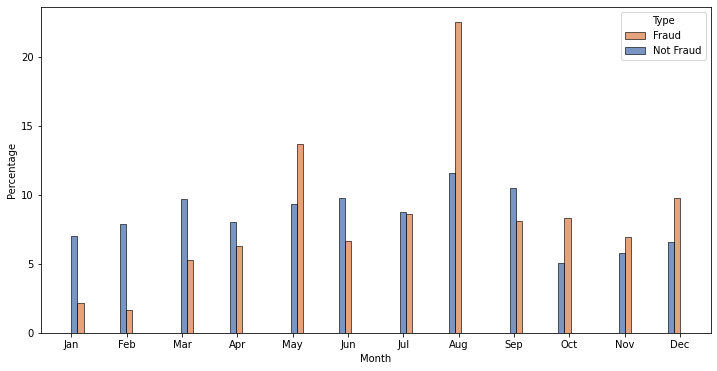

In [20]:
#month vs fraud
ax=sns.histplot(data=credit_card, x="month", hue="Fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Month')
plt.xticks(np.arange(1,13,1))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'])
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### Daily trend

C:\Users\b1379039\AppData\Local\Temp\ipykernel_6180\3150562307.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])


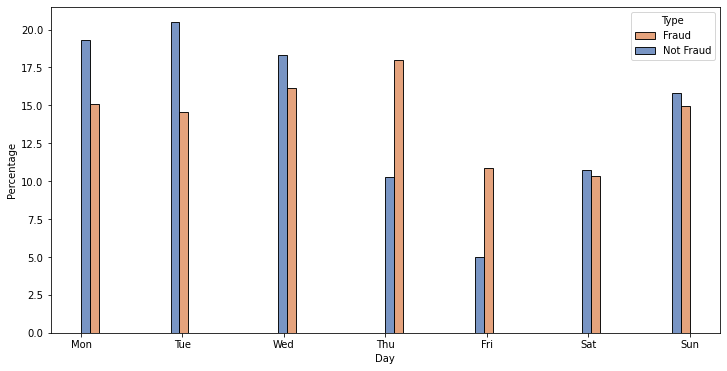

In [21]:
ax=sns.histplot(data = credit_card, x="day", hue="Fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax.set_ylabel('Percentage')
ax.set_xlabel('Day')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### DATASET DISTRIBUTION AND A SIMPLE APPROACH OF UNDERSAMPLING

In [22]:
#First Method of solving this problem which comes in mind will be by 
#taking same number of records of the majority class as the minority class

fraud_data = credit_card.loc[credit_card["Fraud"] == 1]
non_fraud_data = credit_card.loc[credit_card["Fraud"] == 0][:1022]

#concating the above dataframes to get a single dataframe
normal_distributed_df = pd.concat([fraud_data, non_fraud_data])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)
# setting up separate dataframes for fraud and non_fraud data for detailed analysis and comparison

print("Fraud Data Shape: ", fraud_data.shape)
print("Non-Fraud Data Shape: ", non_fraud_data.shape)

Fraud Data Shape:  (1022, 11)
Non-Fraud Data Shape:  (1022, 11)


In [23]:
#Now we have exactly 50-50 percent rows of both majority and minority classes

print('No Frauds', round(new_df['Fraud'].value_counts()[0]/len(new_df) * 100 , 2), '% of the dataset')
print('Frauds', round(new_df['Fraud'].value_counts()[1]/len(new_df) * 100 , 2), '% of the dataset')

No Frauds 50.0 % of the dataset
Frauds 50.0 % of the dataset


### ENCODING INDEPENDENT VARIABLE

In [24]:
le = LabelEncoder()
new_df["Merchnum"] = le.fit_transform(new_df['Merchnum'])
new_df["Merch description"] = le.fit_transform(new_df['Merch description'])
new_df["Merch state"] = le.fit_transform(new_df['Merch state'])
new_df["Transtype"] = le.fit_transform(new_df['Transtype'])

### FEATURE SCALING THE DATASET 

In [25]:
df = pd.DataFrame(StandardScaler().fit_transform(new_df), columns=new_df.columns, index=new_df.index)
df

,Recnum,day,month,Cardnum,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
41695,0.373921,1.280883,0.468455,-0.934997,1.227079,-1.163108,0.358556,-0.138674,0.0,1.322675,1.0
299,-0.869619,-1.215423,-0.851901,-0.300915,0.009823,0.733899,-1.062205,0.393393,0.0,-0.513138,-1.0
50319,0.632987,1.780145,0.732526,-0.313086,-0.894957,0.590816,-0.688321,-0.891307,0.0,0.054580,1.0
59817,0.918308,-0.216900,0.996597,-0.679765,1.199096,0.092332,0.283779,-1.167370,0.0,2.654921,1.0
571,-0.861448,-0.716161,-0.851901,-0.623078,1.315691,1.292385,1.106325,-0.841293,0.0,-0.519058,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
133,-0.874605,1.780145,-0.851901,0.481099,-0.960251,0.632356,1.106325,-0.850096,0.0,-0.520783,-1.0
311,-0.869258,-1.215423,-0.851901,-0.190186,1.068509,-1.181570,-1.735198,1.426989,0.0,1.682796,-1.0
87460,1.748706,-0.716161,1.788810,-0.031046,-0.554499,-1.061565,1.106325,-0.850161,0.0,-0.477535,1.0
485,-0.864031,-0.716161,-0.851901,-0.753585,-1.342684,0.881598,1.106325,-0.841616,0.0,-0.470703,-1.0


### SPLITTING THE DATASET

In [26]:
#splitting the dataset
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

X_train = X_train[X_train.Fraud == -1.0]
X_train = X_train.drop(['Fraud'], axis=1)

y_test = X_test['Fraud']
X_test = X_test.drop(['Fraud'], axis=1)

X_train = X_train.values
X_test = X_test.values
X_train.shape

(814, 10)

In [27]:
X_test.shape

(409, 10)

In [28]:
y_test.shape

(409,)

### UNDERCOMPLETE OR GENERAL AUTOENCODER

The Autoencoder model for anomaly detection has some steps as follows: 

Step 1 is the encoder step. The essential information is extracted by a neural network model in this step.

Step 2 is the decoder step. In this step, the model reconstructs the data using the extracted information.

Step 3: Iterate step 1 and step 2 to adjust the model to minimize the difference between input and reconstructed output, until we get good reconstruction results for the training dataset.

Step 4: Make predictions on a dataset that includes outliers.

Step 5: Set up a threshold for outliers/anomalies by comparing the differences between the autoencoder model reconstruction value and the actual value.

Step 6: Identify the data points with the difference higher than the threshold to be outliers or anomalies.

#### INPUT LAYER

In [29]:
# 'tanh' is used for the activation function of the encoded network 
# because it has big learning steps and results in strong or higher gradients

#relu is used on the bottle neck (latent low representation) 
#because model performance is better when trained with relu

#sigmoid is used for binary classification and since we have 
#fraud and non fraudclass then it is good for this problem

#In the input layer, we specified the shape of the dataset. 

input_layer = Input(shape=(X_train.shape[1],))

#### BUILDING THE ENCODER NETWORK

In [30]:

#Note that the encoder requires the number of neurons to decrease with the layers. 
#The last layer in the encoder is the size of the encoded representation, and it is also called the bottleneck.
encoded = Dense(200, activation="tanh", activity_regularizer=regularizers.l1(1e-3))(input_layer)
encoded = Dense(100, activation="tanh", activity_regularizer=regularizers.l1(1e-3))(encoded)
encoded = Dense(2, activation="relu")(encoded)

#### BUILDING THE DECODER NETWORK

In [31]:
# The decoder consists of 3 layers with 12, 25, 50 and 100 neurons, respectively. 
#Opposite from the encoder, the decoder requires the number of neurons to increase with the layers. 
#The output layer in the decoder has the same size as the input layer.

decoded = Dense(100, activation="tanh")(encoded)
decoded = Dense(200, activation="tanh")(decoded)

#### OUTPUT LAYER

In [32]:
output_layer = Dense(X_train.shape[1], activation="sigmoid")(decoded)

#### MODEL CREATION

In [33]:
#After defining the input, encoder, and decoder layers, we create the autoencoder model to combine the layers.
autoencoder = Model(input_layer, output_layer)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 200)               2200      
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
 dense_3 (Dense)             (None, 100)               300       
                                                                 
 dense_4 (Dense)             (None, 200)               20200     
                                                                 
 dense_5 (Dense)             (None, 10)                2010  

In [34]:
# compiling the auto encoder model  with the optimizer of adam and the loss of mse (Mean squared Error).
autoencoder.compile(optimizer="adam", loss="mse")

#When fitting the autoencoder model, we can see that the input and output datasets are the same,
#which is the dataset that contains only the normal data points.

#The epochs of 50 and batch_size of 32 mean the model uses 32 datapoints to update the weights in each iteration, 
#and the model will go through the whole training dataset 50 times.

#shuffle=True will shuffle the dataset before each epoch.

# training the auto encoder model on non fraud data 
history = autoencoder.fit(X_train,X_train,batch_size=128,epochs=200,shuffle=True,validation_data=(X_test, X_test))

Epoch 1/200
7/7 [==============================] - 1s 33ms/step - loss: 1.1257 - val_loss: 1.0015
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.7979 - val_loss: 0.9235
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.7287 - val_loss: 0.9061
Epoch 4/200
7/7 [==============================] - 0s 7ms/step - loss: 0.7095 - val_loss: 0.8962
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.6998 - val_loss: 0.8915
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.8854
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.6858 - val_loss: 0.8796
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 0.6784 - val_loss: 0.8763
Epoch 9/200
7/7 [==============================] - 0s 6ms/step - loss: 0.6726 - val_loss: 0.8751
Epoch 10/200
7/7 [==============================] - 0s 6ms/step - loss: 0.6666 - val_loss: 0.8754
Epoch 11/200
7/7 [==========

7/7 [==============================] - 0s 6ms/step - loss: 0.5887 - val_loss: 0.8717
Epoch 168/200
7/7 [==============================] - 0s 6ms/step - loss: 0.5888 - val_loss: 0.8751
Epoch 169/200
7/7 [==============================] - 0s 6ms/step - loss: 0.5888 - val_loss: 0.8764
Epoch 170/200
7/7 [==============================] - 0s 6ms/step - loss: 0.5887 - val_loss: 0.8733
Epoch 171/200
7/7 [==============================] - 0s 6ms/step - loss: 0.5888 - val_loss: 0.8719
Epoch 172/200
7/7 [==============================] - 0s 6ms/step - loss: 0.5897 - val_loss: 0.8705
Epoch 173/200
7/7 [==============================] - 0s 6ms/step - loss: 0.5892 - val_loss: 0.8738
Epoch 174/200
7/7 [==============================] - 0s 6ms/step - loss: 0.5890 - val_loss: 0.8735
Epoch 175/200
7/7 [==============================] - 0s 6ms/step - loss: 0.5887 - val_loss: 0.8736
Epoch 176/200
7/7 [==============================] - 0s 6ms/step - loss: 0.5884 - val_loss: 0.8745
Epoch 177/200
7/7 [=====

Text(0.5, 1.0, 'Loss Curves')

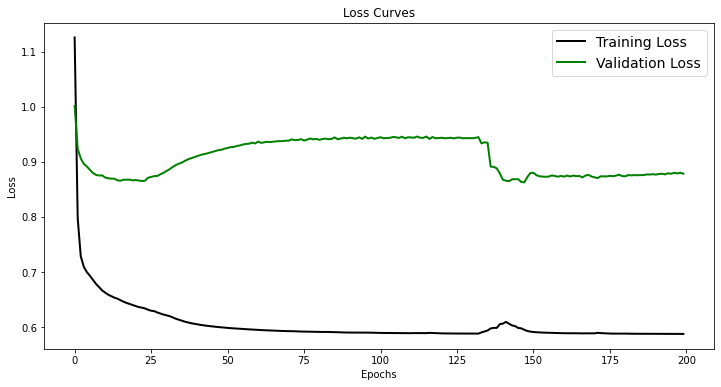

In [35]:
# Loss curve

plt.plot(history.history["loss"], "black", linewidth=2.0)
plt.plot(history.history["val_loss"], "green", linewidth=2.0)
plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Loss Curves", fontsize=12)

This chart visualizes the training and validation loss changes during the model fitting. The x-axis is the number of epochs, and the y axis is the loss. We can see that both training and validation losses decrease with the increase of epochs.

In [36]:
#we have an autoencoder model, let's use it to predict the outliers.
#Firstly, we use .predict to get the reconstruction value for the testing data 
#set containing the usual data points and the outliers.


# Predict anomalies/outliers in the training dataset
prediction = autoencoder.predict(X_test)

13/13 [==============================] - 0s 1ms/step


In [37]:
# Get the mean squared error between actual and reconstruction/prediction
prediction_loss = tf.keras.losses.mse(prediction, X_test)

In [38]:
# a threshold is set to identify the outliers. 
#This threshold can be based on percentile, standard deviation, or other methods. 
#We use 98% loss as the threshold to identify 2% of the data as outliers in this example.


# Check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 50)
print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')

The prediction loss threshold for 2% of outliers is 0.71


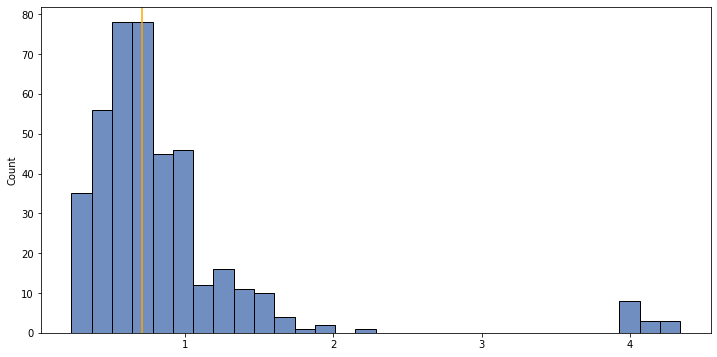

In [39]:
# Visualize the threshold
sns.histplot(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')


In [40]:
# Check the model performance at 2% threshold
threshold_prediction = [-1.0 if i < loss_threshold else 1 for i in prediction_loss]
threshold_prediction

[1,
 -1.0,
 -1.0,
 -1.0,
 1,
 -1.0,
 1,
 1,
 -1.0,
 1,
 1,
 1,
 -1.0,
 -1.0,
 1,
 1,
 -1.0,
 -1.0,
 1,
 -1.0,
 1,
 -1.0,
 -1.0,
 -1.0,
 1,
 -1.0,
 -1.0,
 -1.0,
 1,
 1,
 1,
 -1.0,
 1,
 1,
 -1.0,
 -1.0,
 1,
 1,
 1,
 -1.0,
 -1.0,
 1,
 1,
 -1.0,
 1,
 -1.0,
 -1.0,
 1,
 -1.0,
 -1.0,
 1,
 -1.0,
 -1.0,
 -1.0,
 1,
 -1.0,
 -1.0,
 1,
 -1.0,
 1,
 1,
 -1.0,
 -1.0,
 1,
 1,
 -1.0,
 1,
 1,
 1,
 1,
 -1.0,
 1,
 1,
 -1.0,
 1,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1,
 1,
 -1.0,
 1,
 -1.0,
 -1.0,
 -1.0,
 1,
 1,
 -1.0,
 -1.0,
 -1.0,
 1,
 -1.0,
 1,
 1,
 1,
 -1.0,
 -1.0,
 -1.0,
 1,
 1,
 1,
 1,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1,
 1,
 1,
 1,
 -1.0,
 -1.0,
 -1.0,
 1,
 -1.0,
 1,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1,
 -1.0,
 -1.0,
 1,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1,
 1,
 -1.0,
 -1.0,
 -1.0,
 1,
 -1.0,
 1,
 -1.0,
 -1.0,
 1,
 1,
 -1.0,
 -1.0,
 1,
 1,
 1,
 1,
 1,
 -1.0,
 1,
 -1.0,
 -1.0,
 -1.0,
 1,
 1,
 1,
 -1.0,
 -1.0,
 1,
 1,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1,
 1,
 -1.0,
 1,
 1,
 1,
 -1.0,
 -1.0,
 1,


In [41]:
# Check the prediction performance
print(classification_report(y_test, threshold_prediction))

              precision    recall  f1-score   support

        -1.0       0.75      0.74      0.74       208
         1.0       0.73      0.75      0.74       201

    accuracy                           0.74       409
   macro avg       0.74      0.74      0.74       409
weighted avg       0.74      0.74      0.74       409



In [42]:
# Predict anomalies/outliers in the training dataset
prediction = autoencoder.predict(X_test)
prediction.shape

13/13 [==============================] - 0s 1ms/step


(409, 10)

In [43]:
#mse here is basically the reconstruction error, 
#if the model has learned the normal datapoints well,
#then this error should be less on normal points, and high on fraud points.

mse = np.mean(np.power(X_test - prediction, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'Fraud':y_test})

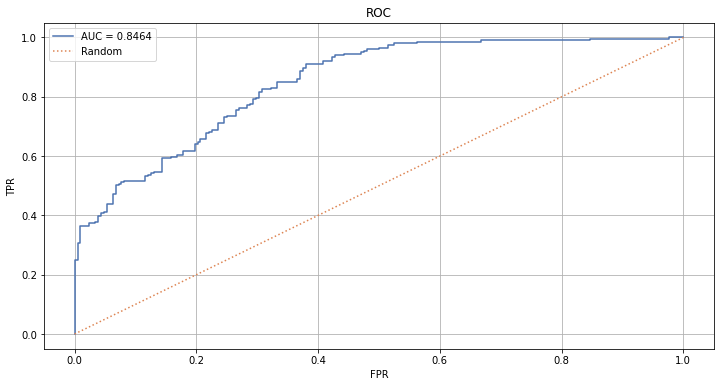

In [44]:
from sklearn.metrics import (roc_curve,confusion_matrix,auc)
fpr, tpr, thres = roc_curve(error_df.Fraud, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc) 
plt.plot([0,1], [0,1], ':', label = 'Random') 
plt.legend() 
plt.grid() 
plt.ylabel("TPR") 
plt.xlabel("FPR") 
plt.title('ROC') 
plt.show()

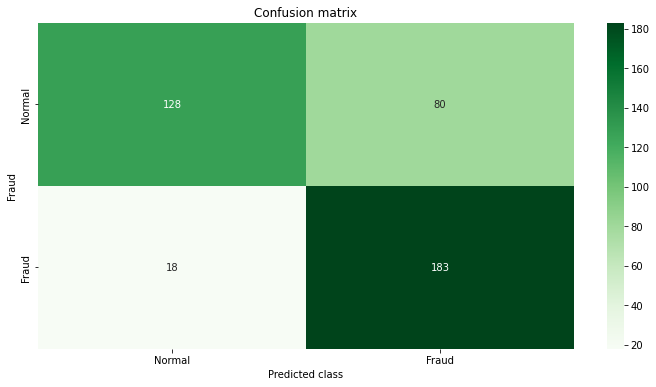

In [45]:
LABELS = ['Normal', 'Fraud']
threshold = 0.63
y_pred = [1 if e > threshold else -1.0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.Fraud, y_pred)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='Greens');
plt.title("Confusion matrix")
plt.ylabel('Fraud')
plt.xlabel('Predicted class')
plt.show()

### VARIATIONAL AUTOENCODER

In [46]:
disable_eager_execution()

In [47]:
# network parameters and learning parameters
original_dim = X_train.shape[1]
input_shape = (original_dim, )
intermediate_dim = 200
batch_size = 256
latent_dim = 2
epochs = 400
epsilon_std = 1.0

In [48]:
#sampling random number
from keras import backend as K
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch, latent_dim), mean=0.,
                              stddev=epsilon_std)  # by default, random_normal has mean=0 and std=1.0
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [49]:
# sampling 
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 encoding (Dense)               (None, 200)          2200        ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            402         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            402         ['encoding[0][0]']               
                                                                                            

In [50]:
# decoder model
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 200)               600       
                                                                 
 flat_decoded (Dense)        (None, 10)                2010      
                                                                 
Total params: 2,610
Trainable params: 2,610
Non-trainable params: 0
_________________________________________________________________


In [51]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])

In [52]:

# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10)]              0         
                                                                 
 encoder (Functional)        [(None, 2),               3004      
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 10)                2610      
                                                                 
Total params: 5,614
Trainable params: 5,614
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Defina VAE Loss Function
def rec_loss(y_true, y_pred):
    return K.sum(K.square(y_true - y_pred), axis=-1)

def kl_loss(y_true, y_pred):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def vae_loss(x, decoded_mean):
    rec_loss = K.sum(K.square(x - decoded_mean), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean((rec_loss + kl_loss) / 2)

In [54]:

# vae.compile(optimizer='adam', loss=vae_loss)
vae.compile(optimizer='adam', loss=vae_loss, metrics=[rec_loss, kl_loss],experimental_run_tf_function=False)
vae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10)]              0         
                                                                 
 encoder (Functional)        [(None, 2),               3004      
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 10)                2610      
                                                                 
Total params: 5,614
Trainable params: 5,614
Non-trainable params: 0
_________________________________________________________________


In [55]:
from tensorflow.keras import metrics
history = vae.fit(X_train,X_train,batch_size=batch_size,epochs=epochs,shuffle=True,validation_data=(X_test, X_test))


Train on 814 samples, validate on 409 samples
Epoch 1/400
814/814 [==============================] - 0s 188us/sample - loss: 6.0661 - rec_loss: 12.0728 - kl_loss: 0.0594 - val_loss: 5.7029 - val_rec_loss: 11.3385 - val_kl_loss: 0.0674
Epoch 2/400
814/814 [==============================] - 0s 12us/sample - loss: 5.9056 - rec_loss: 11.7542 - kl_loss: 0.0569 - val_loss: 5.6055 - val_rec_loss: 11.1391 - val_kl_loss: 0.0718
Epoch 3/400
814/814 [==============================] - 0s 14us/sample - loss: 5.7554 - rec_loss: 11.4407 - kl_loss: 0.0700 - val_loss: 5.5318 - val_rec_loss: 10.9776 - val_kl_loss: 0.0860
Epoch 4/400
814/814 [==============================] - 0s 12us/sample - loss: 5.6368 - rec_loss: 11.1804 - kl_loss: 0.0933 - val_loss: 5.4587 - val_rec_loss: 10.8075 - val_kl_loss: 0.1099
Epoch 5/400
814/814 [==============================] - 0s 14us/sample - loss: 5.4893 - rec_loss: 10.8522 - kl_loss: 0.1263 - val_loss: 5.3838 - val_rec_loss: 10.6268 - val_kl_loss: 0.1407
Epoch 6/400
8

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Epoch 13/400
814/814 [==============================] - 0s 14us/sample - loss: 4.4530 - rec_loss: 8.6152 - kl_loss: 0.2908 - val_loss: 4.8283 - val_rec_loss: 9.4384 - val_kl_loss: 0.2183
Epoch 14/400
814/814 [==============================] - 0s 14us/sample - loss: 4.3727 - rec_loss: 8.4468 - kl_loss: 0.2985 - val_loss: 4.7704 - val_rec_loss: 9.3283 - val_kl_loss: 0.2125
Epoch 15/400
814/814 [==============================] - 0s 12us/sample - loss: 4.2891 - rec_loss: 8.2822 - kl_loss: 0.2961 - val_loss: 4.7488 - val_rec_loss: 9.2999 - val_kl_loss: 0.1976
Epoch 16/400
814/814 [==============================] - 0s 14us/sample - loss: 4.1772 - rec_loss: 8.0831 - kl_loss: 0.2712 - val_loss: 4.6875 - val_rec_loss: 9.1949 - val_kl_loss: 0.1801
Epoch 17/400
814/814 [==============================] - 0s 12us/sample - loss: 4.1114 - rec_loss: 7.9809 - kl_loss: 0.2419 - val_loss: 4.6972 - val_rec_loss: 9.2259 - val_kl_loss: 0.1684
Epoch 18/400
814/814 [==============================] - 0s 12us/s

Epoch 57/400
814/814 [==============================] - 0s 12us/sample - loss: 3.4197 - rec_loss: 6.8344 - kl_loss: 0.0051 - val_loss: 4.4391 - val_rec_loss: 8.8545 - val_kl_loss: 0.0238
Epoch 58/400
814/814 [==============================] - 0s 12us/sample - loss: 3.4186 - rec_loss: 6.8327 - kl_loss: 0.0046 - val_loss: 4.4460 - val_rec_loss: 8.8685 - val_kl_loss: 0.0236
Epoch 59/400
814/814 [==============================] - 0s 14us/sample - loss: 3.4179 - rec_loss: 6.8314 - kl_loss: 0.0043 - val_loss: 4.4462 - val_rec_loss: 8.8688 - val_kl_loss: 0.0235
Epoch 60/400
814/814 [==============================] - 0s 12us/sample - loss: 3.4147 - rec_loss: 6.8252 - kl_loss: 0.0042 - val_loss: 4.4423 - val_rec_loss: 8.8618 - val_kl_loss: 0.0228
Epoch 61/400
814/814 [==============================] - 0s 12us/sample - loss: 3.4149 - rec_loss: 6.8259 - kl_loss: 0.0040 - val_loss: 4.4413 - val_rec_loss: 8.8605 - val_kl_loss: 0.0221
Epoch 62/400
814/814 [==============================] - 0s 12us/s

Epoch 101/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3872 - rec_loss: 6.7731 - kl_loss: 0.0012 - val_loss: 4.4357 - val_rec_loss: 8.8569 - val_kl_loss: 0.0145
Epoch 102/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3869 - rec_loss: 6.7727 - kl_loss: 0.0012 - val_loss: 4.4368 - val_rec_loss: 8.8592 - val_kl_loss: 0.0143
Epoch 103/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3874 - rec_loss: 6.7737 - kl_loss: 0.0012 - val_loss: 4.4358 - val_rec_loss: 8.8573 - val_kl_loss: 0.0142
Epoch 104/400
814/814 [==============================] - 0s 14us/sample - loss: 3.3868 - rec_loss: 6.7724 - kl_loss: 0.0011 - val_loss: 4.4352 - val_rec_loss: 8.8563 - val_kl_loss: 0.0141
Epoch 105/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3872 - rec_loss: 6.7733 - kl_loss: 0.0010 - val_loss: 4.4351 - val_rec_loss: 8.8564 - val_kl_loss: 0.0137
Epoch 106/400
814/814 [==============================] - 0s 

Epoch 144/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3811 - rec_loss: 6.7614 - kl_loss: 7.2349e-04 - val_loss: 4.4334 - val_rec_loss: 8.8555 - val_kl_loss: 0.0114
Epoch 145/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3808 - rec_loss: 6.7609 - kl_loss: 7.5849e-04 - val_loss: 4.4343 - val_rec_loss: 8.8572 - val_kl_loss: 0.0114
Epoch 146/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3801 - rec_loss: 6.7595 - kl_loss: 7.4154e-04 - val_loss: 4.4345 - val_rec_loss: 8.8576 - val_kl_loss: 0.0114
Epoch 147/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3807 - rec_loss: 6.7608 - kl_loss: 7.3585e-04 - val_loss: 4.4338 - val_rec_loss: 8.8561 - val_kl_loss: 0.0115
Epoch 148/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3807 - rec_loss: 6.7606 - kl_loss: 7.2802e-04 - val_loss: 4.4338 - val_rec_loss: 8.8561 - val_kl_loss: 0.0114
Epoch 149/400
814/814 [=================

Epoch 187/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3785 - rec_loss: 6.7564 - kl_loss: 5.5385e-04 - val_loss: 4.4324 - val_rec_loss: 8.8548 - val_kl_loss: 0.0099
Epoch 188/400
814/814 [==============================] - 0s 14us/sample - loss: 3.3792 - rec_loss: 6.7579 - kl_loss: 5.7543e-04 - val_loss: 4.4328 - val_rec_loss: 8.8556 - val_kl_loss: 0.0099
Epoch 189/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3783 - rec_loss: 6.7561 - kl_loss: 5.5341e-04 - val_loss: 4.4321 - val_rec_loss: 8.8544 - val_kl_loss: 0.0099
Epoch 190/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3780 - rec_loss: 6.7555 - kl_loss: 5.2844e-04 - val_loss: 4.4325 - val_rec_loss: 8.8553 - val_kl_loss: 0.0097
Epoch 191/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3786 - rec_loss: 6.7567 - kl_loss: 5.2082e-04 - val_loss: 4.4332 - val_rec_loss: 8.8568 - val_kl_loss: 0.0096
Epoch 192/400
814/814 [=================

Epoch 230/400
814/814 [==============================] - 0s 14us/sample - loss: 3.3771 - rec_loss: 6.7538 - kl_loss: 5.1006e-04 - val_loss: 4.4323 - val_rec_loss: 8.8557 - val_kl_loss: 0.0089
Epoch 231/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3778 - rec_loss: 6.7552 - kl_loss: 5.0760e-04 - val_loss: 4.4324 - val_rec_loss: 8.8560 - val_kl_loss: 0.0088
Epoch 232/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3779 - rec_loss: 6.7554 - kl_loss: 5.1836e-04 - val_loss: 4.4324 - val_rec_loss: 8.8560 - val_kl_loss: 0.0088
Epoch 233/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3776 - rec_loss: 6.7547 - kl_loss: 5.5770e-04 - val_loss: 4.4337 - val_rec_loss: 8.8587 - val_kl_loss: 0.0086
Epoch 234/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3776 - rec_loss: 6.7546 - kl_loss: 5.6719e-04 - val_loss: 4.4312 - val_rec_loss: 8.8539 - val_kl_loss: 0.0086
Epoch 235/400
814/814 [=================

Epoch 273/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3767 - rec_loss: 6.7527 - kl_loss: 6.0399e-04 - val_loss: 4.4334 - val_rec_loss: 8.8587 - val_kl_loss: 0.0081
Epoch 274/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3762 - rec_loss: 6.7518 - kl_loss: 5.9341e-04 - val_loss: 4.4319 - val_rec_loss: 8.8557 - val_kl_loss: 0.0081
Epoch 275/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3766 - rec_loss: 6.7526 - kl_loss: 6.4307e-04 - val_loss: 4.4338 - val_rec_loss: 8.8596 - val_kl_loss: 0.0081
Epoch 276/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3766 - rec_loss: 6.7526 - kl_loss: 7.3221e-04 - val_loss: 4.4328 - val_rec_loss: 8.8576 - val_kl_loss: 0.0081
Epoch 277/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3766 - rec_loss: 6.7523 - kl_loss: 7.6741e-04 - val_loss: 4.4335 - val_rec_loss: 8.8590 - val_kl_loss: 0.0081
Epoch 278/400
814/814 [=================

Epoch 316/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3771 - rec_loss: 6.7535 - kl_loss: 7.6500e-04 - val_loss: 4.4331 - val_rec_loss: 8.8584 - val_kl_loss: 0.0077
Epoch 317/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3763 - rec_loss: 6.7517 - kl_loss: 8.3091e-04 - val_loss: 4.4336 - val_rec_loss: 8.8592 - val_kl_loss: 0.0079
Epoch 318/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3766 - rec_loss: 6.7523 - kl_loss: 7.6409e-04 - val_loss: 4.4342 - val_rec_loss: 8.8603 - val_kl_loss: 0.0080
Epoch 319/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3769 - rec_loss: 6.7530 - kl_loss: 8.0381e-04 - val_loss: 4.4324 - val_rec_loss: 8.8569 - val_kl_loss: 0.0080
Epoch 320/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3758 - rec_loss: 6.7506 - kl_loss: 9.7342e-04 - val_loss: 4.4356 - val_rec_loss: 8.8633 - val_kl_loss: 0.0078
Epoch 321/400
814/814 [=================

814/814 [==============================] - 0s 12us/sample - loss: 3.3770 - rec_loss: 6.7532 - kl_loss: 8.8926e-04 - val_loss: 4.4329 - val_rec_loss: 8.8582 - val_kl_loss: 0.0077
Epoch 360/400
814/814 [==============================] - 0s 12us/sample - loss: 3.3757 - rec_loss: 6.7503 - kl_loss: 0.0011 - val_loss: 4.4339 - val_rec_loss: 8.8598 - val_kl_loss: 0.0079
Epoch 361/400
814/814 [==============================] - 0s 14us/sample - loss: 3.3739 - rec_loss: 6.7465 - kl_loss: 0.0013 - val_loss: 4.4329 - val_rec_loss: 8.8577 - val_kl_loss: 0.0082
Epoch 362/400
814/814 [==============================] - 0s 14us/sample - loss: 3.3771 - rec_loss: 6.7529 - kl_loss: 0.0014 - val_loss: 4.4330 - val_rec_loss: 8.8575 - val_kl_loss: 0.0085
Epoch 363/400
814/814 [==============================] - 0s 14us/sample - loss: 3.3780 - rec_loss: 6.7544 - kl_loss: 0.0015 - val_loss: 4.4339 - val_rec_loss: 8.8595 - val_kl_loss: 0.0083
Epoch 364/400
814/814 [==============================] - 0s 14us/sampl

In [56]:
# plot loss history
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Loss Curves')

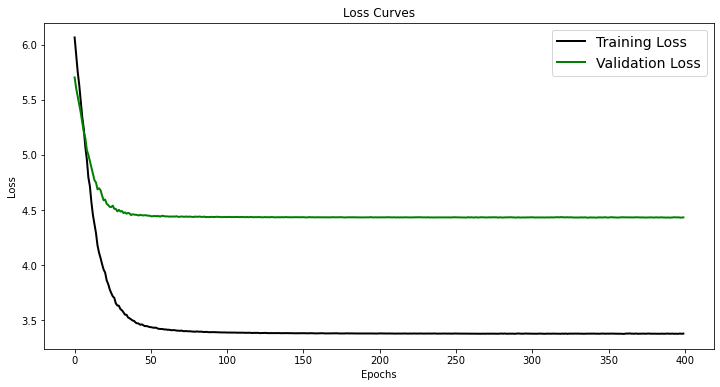

In [57]:
# Loss curve

plt.plot(history.history["loss"], "black", linewidth=2.0)
plt.plot(history.history["val_loss"], "green", linewidth=2.0)
plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Loss Curves", fontsize=12)